In [ ]:
# LightGBM, GradientBooting, Xgboot
# Prevent Overfitting : 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import os
import plotly.express as px
import pandas_profiling as pp
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# import tensorflow as tf
# import tensorflow.keras
# import tensorflow.keras.layers as Layers
# import tensorflow.keras.activations as Actications
# import tensorflow.keras.models as Models
# import tensorflow.keras.optimizers as Optimizer
# import tensorflow.keras.metrics as Metrics
# import tensorflow.keras.utils as Utils
# from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
# import tensorflow.keras.backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "./drive/My Drive/devC_data/"

In [ ]:
temp = pd.read_csv(path + 'temp.csv')
community = pd.read_csv(path + 'pagerank.csv')
arpu_train = pd.read_csv(path + "arpu_train.csv")
arpu_test = pd.read_csv(path + "arpu_test.csv")

In [ ]:
loan = pd.read_csv(path + 'loan.csv')
loan = loan.dropna()
recharge = pd.read_csv(path + 'recharge.csv')
recharge = recharge.dropna()


# Extract Features

In [ ]:
import datetime
def get_num_days(data_time):
  try:
    return (datetime.datetime.now() - pd.to_datetime(data_time[:10])).days
  except:
    return 0 
import datetime
def get_date_time(data_col):
  new_col = [(datetime.datetime.now() - datetime.datetime.fromtimestamp(c / 1000)).days * (c > 0) for c in data_col]
  return new_col


## Xử lý các feature cơ bản

In [ ]:
# Hàm prepare_data là hàm tổng hợp xử lý các feature từ các file cho trước
# Phần lớn các feature sẽ được groupy theo msisdn rồi tính các giá trị sum, count, mean, min, max, std

def prepare_data(arpu_train, temp):  

  # Xử lý file loan
  
  loan = pd.read_csv(path + 'loan.csv')
  loan = loan.dropna()
  
  loan['COL_25'] = loan['COL_25'].apply(get_num_days)
  new_loan = loan.groupby('msisdn')[['COL_25']].agg(['min'])
  new_loan.columns = (new_loan.columns.map('_'.join))
  arpu_train = arpu_train.merge(new_loan, on='msisdn', how='left')

  loan['COL_24a'] = loan['COL_24'] * (loan['COL_24'] > 0)
  loan['COL_24b'] = loan['COL_24'] * (loan['COL_24'] < 0)
  new_loan = loan.groupby('msisdn')[['COL_23', 'COL_24', 'COL_24a', 'COL_24b']].agg(['sum', 'count', 'mean', 'min', 'max'])
  new_loan.columns = (new_loan.columns.map('_'.join))
  arpu_train = arpu_train.merge(new_loan, on='msisdn', how='left')

  # Xử lý recharge
  recharge = pd.read_csv(path + 'recharge.csv')
  recharge = recharge.dropna()
  recharge['COL_29'] = recharge['COL_29'].apply(get_num_days)
  new_recharge = recharge.groupby('msisdn')[['COL_29']].agg(['min'])
  new_recharge.columns = (new_recharge.columns.map('_'.join))
  arpu_train = arpu_train.merge(new_recharge, on='msisdn', how='left')

  recharge['COL_30'] = recharge['COL_30'].replace('V', 0)
  recharge['COL_30'] = recharge['COL_30'].replace('C', 1)
  new_recharge = recharge.groupby('msisdn')[['COL_30', 'COL_31']].agg(['sum', 'count', 'mean', 'min', 'max', 'std'])
  new_recharge.columns = (new_recharge.columns.map('_'.join))
  arpu_train = arpu_train.merge(new_recharge, on='msisdn', how='left')
  print("Merged loan, recharge")

  # Xử lý file temp
  new_temp = temp[temp['COL_12'] != 7][['msisdn', 'COL_8']].groupby('msisdn').agg(['sum','count', 'mean', 'min', 'max', 'std'])
  new_temp.columns = (new_temp.columns.map('_'.join))
  arpu_train = arpu_train.merge(new_temp, on='msisdn', how='left')

  new_temp = temp[temp['COL_12'] == 7][['msisdn', 'COL_11', 'UPLOAD_DATA']].groupby('msisdn').agg(['sum','count', 'mean', 'min', 'max', 'std'])
  new_temp.columns = (new_temp.columns.map('_'.join))
  arpu_train = arpu_train.merge(new_temp, on='msisdn', how='left')

  new_temp = temp[['msisdn', 'COL_1']].groupby('msisdn').agg(['sum', 'count', 'mean', 'min', 'max', 'std'])
  new_temp.columns = (new_temp.columns.map('_'.join))
  arpu_train = arpu_train.merge(new_temp, on='msisdn', how='left')

  # Tạo feature thời gian gọi của user theo ngày
  new_temp = temp.dropna()
  new_temp['COL_2'] = new_temp['COL_2'].str[8:10].astype(int)
  day_data = pd.DataFrame()
  for i in range(1, 32):
    day_data = new_temp[new_temp['COL_2'] == i][['msisdn', 'COL_8']].groupby('msisdn').agg(['sum', 'count'])
    day_data.columns = (day_data.columns.map('_'.join))
    day_data.columns = [f'COL_8_day_{i}_sum', f'COL_8_day_{i}_count']
    arpu_train = arpu_train.merge(day_data, on='msisdn', how='left')
  
  # Tạo feature thời gian gọi của user theo tuần
  new_temp = temp.dropna()
  new_temp['COL_2'] = new_temp['COL_2'].str[8:10].astype(int)
  new_temp['COL_2'] = (new_temp['COL_2'] - 1) // 7 + 1
  day_data = pd.DataFrame()
  for i in range(1, 6):
    day_data = new_temp[new_temp['COL_2'] == i][['msisdn', 'COL_8']].groupby('msisdn').agg(['sum', 'count'])
    day_data.columns = (day_data.columns.map('_'.join))
    day_data.columns = [f'COL_8_week_{i}_sum', f'COL_8_week_{i}_count']
    arpu_train = arpu_train.merge(day_data, on='msisdn', how='left')
  
  new_temp = temp[temp['COL_12'] == 7]
  new_temp['COL_2'] = new_temp['COL_2'].str[8:10].astype(int)
  new_temp['COL_2'] = (new_temp['COL_2'] - 1) // 7 + 1
  day_data = pd.DataFrame()
  for i in range(1, 6):
    day_data = new_temp[new_temp['COL_2'] == i][['msisdn', 'COL_11', 'UPLOAD_DATA']].groupby('msisdn').agg(['sum', 'count'])
    day_data.columns = (day_data.columns.map('_'.join))
    day_data.columns = [f'COL_11_week_{i}_sum', f'COL_11_week_{i}_count', f'UPLOAD_DATA_week_{i}_sum', f'UPLOAD_DATA_week_{i}_count']
    arpu_train = arpu_train.merge(day_data, on='msisdn', how='left')
  del new_temp
  print("Merged temp")

  # Xử lý missing values
  arpu_train.COL_15.fillna('H004', inplace=True)
  arpu_train.COL_14.fillna(method='ffill', inplace=True)
  arpu_train.COL_16.fillna(method='ffill', inplace=True)

  arpu_train['COL_17'].fillna(0, inplace=True)
  arpu_train['COL_18'].fillna(0, inplace=True)

  arpu_train['COL_17'] = get_date_time(arpu_train['COL_17'])
  arpu_train['COL_18'] = get_date_time(arpu_train['COL_18'])

  arpu_train['COL_14'] = 2007 - arpu_train['COL_14']
  arpu_train['COL_14'] = arpu_train['COL_14'].replace(2007.0, 0)

  arpu_train['COL_16'] = arpu_train['COL_16'].replace(0, -1)
  arpu_train['COL_16'] = arpu_train['COL_16'].replace('M', 1)
  arpu_train['COL_16'] = arpu_train['COL_16'].replace('F', 0)

  arpu_train['COL_15'] = arpu_train['COL_15'].astype('category').cat.codes
 
  return arpu_train


arpu_train = prepare_data(arpu_train, temp)
arpu_test = prepare_data(arpu_test, temp)

Merged loan, recharge


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

Merged temp
Merged loan, recharge
Merged temp


## Tạo Graph mối quan hệ giữa các user từ file temp và detect community

In [ ]:
import community
import networkx as nx


def create_graph_networkx(data, similarity_score, limit):
    # Tạo graph trong đó node là các user, hai user có cạnh khi mà hai user có gọi điện cho nhau
    G = nx.Graph()
    G.add_nodes_from(data)

    # Thêm các quan hệ giữa user, quan hệ giữa hai user phải thỏa mãn giá trị limit thì mới được thêm, ví dụ như thỏa mãn thời gian gọi tối thiểu, số lượng cuộc gọi, ...
    num_edges = 0
    for i in similarity_score.values:
      if (i[2] > limit):
        G.add_edge(i[0], i[1], similar=i[2])
        num_edges = num_edges + 1
    print("num_edges : ", num_edges)

    return G

def render_group_networkx(data, relation, limit):
    # Sau khi sinh graph, sử dụng thuật toán Louvain để detect community
    # Tham khảo tại https://en.wikipedia.org/wiki/Louvain_modularity
    G = create_graph_networkx(data, relation, limit)
    print("Done load graph")
    partition = nx.clustering(G, weight='weight')
    print("Done calculate best partition")

    partition_df = pd.DataFrame()
    partition_df['id'] = list(partition.keys())
    partition_df['group'] = list(partition.values())
    # Đầu ra sẽ gồm một DataFrame với các trường là id - id của user và group - community user đó thuộc về.
    return partition_df.reset_index(drop=True)


arpu_train = pd.read_csv(path + "arpu_train.csv")
arpu_test = pd.read_csv(path + "arpu_test.csv")
train_msisdn = pd.concat([arpu_train[['msisdn']], arpu_test[['msisdn']]])
del arpu_train, arpu_test
print("Done read train, test")
temp = pd.read_csv(path + 'temp.csv')
temp = temp.fillna(0)
temp = temp.loc[temp.PARTNER_MSISDN != 0]
temp = temp.groupby(['msisdn', 'PARTNER_MSISDN']).sum().reset_index()
print("Size : ", len(temp))
community1 = render_group_networkx(train_msisdn, temp[['msisdn', 'PARTNER_MSISDN', 'COL_8']], 0)


Done read train, test
Size :  5381351
num_edges :  5370033
Done load graph
Done calculate best partition


Dữ liệu sau khi xử lý được lưu lại các file cho lần sau thử nghiệm, dưới đây là bước load các file đã được xử lý

In [ ]:
community = pd.read_csv(path + 'group.csv')
community2 = pd.read_csv(path + 'group_per_week.csv')
community = community.fillna(-1)
arpu_train = pd.read_csv(path + 'prepared_arpu_train.csv')
# arpu_train = arpu_train.drop(['group', 'group_similar', 'group_count', 'group_count_similar', 'group_sum_weight'], axis=1)
arpu_test = pd.read_csv(path + 'prepared_arpu_test.csv',)
# arpu_test = arpu_test.drop(['group', 'group_similar', 'group_count', 'group_count_similar', 'group_sum_weight'] , axis=1)
arpu_train = arpu_train.merge(community, on='msisdn', how='left')
arpu_train = arpu_train.merge(community2, on='msisdn', how='left')
arpu_test = arpu_test.merge(community, on='msisdn', how='left')
arpu_test = arpu_test.merge(community2, on='msisdn', how='left')

Classes là biến chứa các feature dùng để train

In [ ]:
classes = ['COL_14', 
           'COL_16', 'COL_17', 'COL_18', 'COL_19', 'COL_20', 'COL_21', 
           'COL_22', 'COL_27a', 'COL_27b', 'COL_27c', 'COL_27d', 
           'COL_30_sum', 'COL_30_count', 'COL_30_mean' ,
           'COL_31_sum', 'COL_31_mean',
           'COL_31_min', 'COL_31_max',
           'COL_8_sum', 'COL_8_count', 'COL_8_mean',
           'COL_8_min', 'COL_8_max', 
           'COL_11_sum', 'COL_11_count', 'COL_11_mean',
           'UPLOAD_DATA_sum', 'UPLOAD_DATA_count', 'UPLOAD_DATA_mean',
           'UPLOAD_DATA_min', 'UPLOAD_DATA_max',
           'group',
           'group_similar',
           'group_count', 
           'group_count_similar',
           'group_20',
           'group_20_similar',
           'group_count_1_similar',
           'group_count_1',
           'group_30',
           'group_similar_50',
           'group_new_50',
           'group_new_20',
           ]

for i in range(1, 6):
  classes.append(f'COL_8_week_{i}_sum')
  classes.append(f'COL_8_week_{i}_count')
for i in range(10, 32, 7):
  classes.append(f'group_end_day{i}')
  classes.append(f'group_count_end_day{i}')
for i in range(10, 100, 10):
  classes.append(f'group_limit{i}')
for i in range(10, 60, 10):
  classes.append(f'group_count_limit{i}')
arpu_train = arpu_train.fillna(0)
arpu_test = arpu_test.fillna(0)
arpu_train.head()

,msisdn,label,COL_13,COL_14,COL_15,COL_16,COL_17,COL_18,COL_19,COL_20,COL_21,COL_22,COL_27a,COL_27b,COL_27c,COL_27d,COL_25_min,COL_23_sum,COL_23_count,COL_23_mean,COL_23_min,COL_23_max,COL_23_std,COL_24_sum,COL_24_count,COL_24_mean,COL_24_min,COL_24_max,COL_24_std,COL_24a_sum,COL_24a_count,COL_24a_mean,COL_24a_min,COL_24a_max,COL_24a_std,COL_24b_sum,COL_24b_count,COL_24b_mean,COL_24b_min,COL_24b_max,...,group_count_similar,group_20,group_20_similar,group_count_1_similar,group_count_1,group_30,group_similar_50,group_new_50,group_new_20,group_dendrogram,group_dendrogram_2,group_35,Unnamed: 0_y,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,group_end_day10,group_end_day17,group_end_day24,group_end_day31,group_count_end_day10,group_count_end_day17,group_count_end_day24,group_count_end_day31,group_limit0,group_limit10,group_limit20,group_limit30,group_limit40,group_limit50,group_limit60,group_limit70,group_limit80,group_limit90,group_count_limit0,group_count_limit10,group_count_limit20,group_count_limit30,group_count_limit40,group_count_limit50
0,00010016bb53e8e3c82e,0,B240008,42.0,4,1,1041,2803,90909.093750,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.000,312.0,1.0,2.0,0.5,0.0,1.0,0.707107,15000000.0,2.0,7500000.0,-100000000.0,115000000.0,1.520280e+08,115000000.0,2.0,57500000.0,-0.0,115000000.0,8.131728e+07,-100000000.0,2.0,-50000000.0,-100000000.0,0.0,...,969,231.0,1121.0,1309.0,109.0,12.0,1233.0,83.0,123.0,132.0,149.0,116.0,0,0,0,0,84.0,103.0,117.0,129.0,84.0,100.0,122.0,127.0,113.0,37.0,118.0,115.0,100.0,92.0,99.0,89.0,54.0,70.0,125.0,128.0,109.0,120.0,90.0,80.0
1,0001007187b4881379a9,0,H004016,33.0,20,1,5029,1647,28211.099609,6296.094971,0.0,5500.0,1715877.80,25998.148485,11411.651071,23047.690,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,243,71.0,961.0,784.0,649.0,23.0,511.0,325.0,43.0,121.0,366.0,144.0,1,1,1,1,257.0,205.0,105.0,36.0,263.0,198.0,20.0,143.0,137.0,146.0,149.0,329.0,87.0,132.0,295.0,149.0,264.0,258.0,4.0,21.0,226.0,7.0,6.0,6.0
2,000100829f9d67fff3cc,1,H004004,40.0,20,1,3155,3088,219060.570312,45312.064453,0.0,93923.5,2127569.32,32235.898788,25150.943504,30748.625,307.0,4.0,8.0,0.5,0.0,1.0,0.534522,60000000.0,8.0,7500000.0,-100000000.0,115000000.0,1.149223e+08,460000000.0,8.0,57500000.0,-0.0,115000000.0,6.147009e+07,-400000000.0,8.0,-50000000.0,-100000000.0,0.0,...,328,9.0,193.0,226.0,3267.0,108.0,188.0,4.0,354.0,4.0,4.0,322.0,2,2,2,2,288.0,187.0,4.0,31.0,293.0,147.0,24.0,27.0,30.0,25.0,133.0,348.0,351.0,347.0,5.0,319.0,169.0,232.0,31.0,25.0,335.0,57.0,209.0,320.0
3,000100a5e09da7ad6649,0,0,40.0,20,1,0,0,125431.250000,106981.250000,0.0,750.0,2549419.98,38051.044478,19134.960835,34260.940,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,218,98.0,134.0,231.0,85.0,4069.0,5051.0,431.0,388.0,117.0,139.0,400.0,3,3,3,3,191.0,78.0,109.0,122.0,189.0,73.0,113.0,108.0,115.0,147.0,337.0,315.0,308.0,389.0,382.0,364.0,348.0,342.0,119.0,285.0,368.0,341.0,321.0,369.0
4,000100d7f3d9e70f62b0,0,0,40.0,20,1,0,0,201915.429688,71909.789062,0.0,64000.0,2142873.94,32467.786970,29537.371300,25494.170,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,473,296.0,397.0,1158.0,317.0,352.0,357.0,531.0,76.0,394.0,600.0,467.0,4,4,4,4,419.0,359.0,430.0,90.0,424.0,29.0,413.0,95.0,373.0,398.0,124.0,406.0,331.0,468.0,1.0,271.0,47.0,279.0,363.0,403.0,149.0,60.0,403.0,444.0


In [ ]:
classes

['COL_14',
 'COL_16',
 'COL_17',
 'COL_18',
 'COL_19',
 'COL_20',
 'COL_21',
 'COL_22',
 'COL_27a',
 'COL_27b',
 'COL_27c',
 'COL_27d',
 'COL_30_sum',
 'COL_30_count',
 'COL_30_mean',
 'COL_31_sum',
 'COL_31_mean',
 'COL_31_min',
 'COL_31_max',
 'COL_8_sum',
 'COL_8_count',
 'COL_8_mean',
 'COL_8_min',
 'COL_8_max',
 'COL_11_sum',
 'COL_11_count',
 'COL_11_mean',
 'UPLOAD_DATA_sum',
 'UPLOAD_DATA_count',
 'UPLOAD_DATA_mean',
 'UPLOAD_DATA_min',
 'UPLOAD_DATA_max',
 'group',
 'group_similar',
 'group_count',
 'group_count_similar',
 'group_20',
 'group_20_similar',
 'group_count_1_similar',
 'group_count_1',
 'group_30',
 'group_similar_50',
 'group_new_50',
 'group_new_20',
 'COL_8_week_1_sum',
 'COL_8_week_1_count',
 'COL_8_week_2_sum',
 'COL_8_week_2_count',
 'COL_8_week_3_sum',
 'COL_8_week_3_count',
 'COL_8_week_4_sum',
 'COL_8_week_4_count',
 'COL_8_week_5_sum',
 'COL_8_week_5_count',
 'group_end_day10',
 'group_count_end_day10',
 'group_end_day17',
 'group_count_end_day17',
 'gro

In [ ]:
exclude_classes = ['msisdn', 'label', 'COL_13']
classes = arpu_train.columns
classes = classes[3:]
classes

Index(['COL_14', 'COL_15', 'COL_16', 'COL_17', 'COL_18', 'COL_19', 'COL_20',
       'COL_21', 'COL_22', 'COL_27a',
       ...
       'group_limit0', 'group_limit10', 'group_limit20', 'group_limit30',
       'group_limit40', 'group_limit50', 'group_limit60', 'group_limit70',
       'group_limit80', 'group_limit90'],
      dtype='object', length=205)

## Tách dữ liệu vào tập train và tập validation

In [ ]:
np.random.seed(0)
msk = np.random.rand(len(arpu_train)) <= 0.8
train_data = arpu_train[msk]
val_data = arpu_train[~msk]
msk = np.random.rand(len(val_data)) <= 0.001
test_data = val_data[msk]
val_data = val_data[~msk]
print(len(train_data), len(val_data), len(test_data), len(arpu_train))

46244 11461 16 57721


In [ ]:
def make_input(data):
  x = data[classes]
  y = data['label']
  # x = convert_to_tensor(x)
  # y = convert_to_tensor(y, tf.int32)
  return np.array(x), np.array(y)
x_train, y_train = make_input(train_data)
print(x_train.shape)
x_val, y_val = make_input(val_data)
x_test, y_test = make_input(test_data)

# Biến weights là biến đánh trọng số cho nhãn, vì đây là bài toán imbalance giữa label 0 và 1
weights = class_weight.compute_class_weight('balanced',
                                            np.unique(y_train),
                                            y_train)
weights = {i : weights[i] for i in range(2)}
print(weights)

(46244, 76)
{0: 0.550471383677745, 1: 5.4533018867924525}


# Xây dựng model

## RandomForest Regressor

In [ ]:
# Random forest
from sklearn.ensemble import RandomForestRegressor
sample_weights = [weights[c] for c in y_train]

clf = RandomForestRegressor(n_estimators=16, max_depth=8)
clf.fit(x_train, y_train, sample_weight=sample_weights)
print(clf.score(x_train, y_train))
print(clf.score(x_val, y_val))
print(clf.score(x_test, y_test))

-0.4315480248166179
-0.5634176106001567
0.28684073917105757


In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
x_base = x_val
y_base = y_val
preds = clf.predict(x_base)
# preds = np.random.rand(len(y_base))
preds_01 = (preds >= 0.5) * 1
roc_auc = roc_auc_score(y_base, preds)

print('Avg GINI score:', 2*roc_auc - 1)
print('Accuracy : ', accuracy_score(y_base, preds_01))
print('f1_score', f1_score(y_base, preds_01), precision_score(y_base, preds_01), recall_score(y_base, preds_01))
print(sum(preds_01), len(preds_01))

Avg GINI score: 0.7218640366685889
Accuracy :  0.863493174658733
f1_score 0.46058091286307057 0.35653104925053536 0.650390625
934 5714


## Cat Boost

In [ ]:
#Cat Boost
!pip install catboost

from catboost import CatBoostRegressor
cat_weights = [weights[c] for c in y_train]
# print(y_train)
feature_weights = {'0':weights[0], '1':weights[1]}
gbm = CatBoostRegressor(eval_metric='AUC',
                        use_best_model=True,
                        iterations=2000, 
                        learning_rate=0.01, 
                        depth=7,
                        # penalties_coefficient=weights[1],
                        # feature_weights=feature_weights,
                        )
gbm.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_val, y_val)], verbose=500)

     |████████████████████████████████| 66.1MB 131kB/s 
0:	test: 0.7782458	test1: 0.7681436	best: 0.7681436 (0)	total: 115ms	remaining: 3m 49s
500:	test: 0.8818303	test1: 0.8695052	best: 0.8695052 (500)	total: 27.2s	remaining: 1m 21s
1000:	test: 0.9025808	test1: 0.8773712	best: 0.8773820 (999)	total: 54.6s	remaining: 54.5s
1500:	test: 0.9170494	test1: 0.8815213	best: 0.8815213 (1500)	total: 1m 21s	remaining: 27.1s
1999:	test: 0.9283709	test1: 0.8834006	best: 0.8834006 (1999)	total: 1m 48s	remaining: 0us

bestTest = 0.8834006339
bestIteration = 1999



In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
x_base = x_val
y_base = y_val
preds = gbm.predict(x_base)
# preds = np.random.rand(len(y_base))
preds_01 = (preds >= 0.5) * 1
roc_auc = roc_auc_score(y_base, preds)

print('Avg GINI score:', 2*roc_auc - 1)
print('Accuracy : ', accuracy_score(y_base, preds_01))
print('f1_score', f1_score(y_base, preds_01), precision_score(y_base, preds_01), recall_score(y_base, preds_01))
print(sum(preds_01), len(preds_01))

Avg GINI score: 0.7668012677252363
Accuracy :  0.9319431114213419
f1_score 0.4967741935483871 0.8279569892473119 0.3548387096774194
465 11461


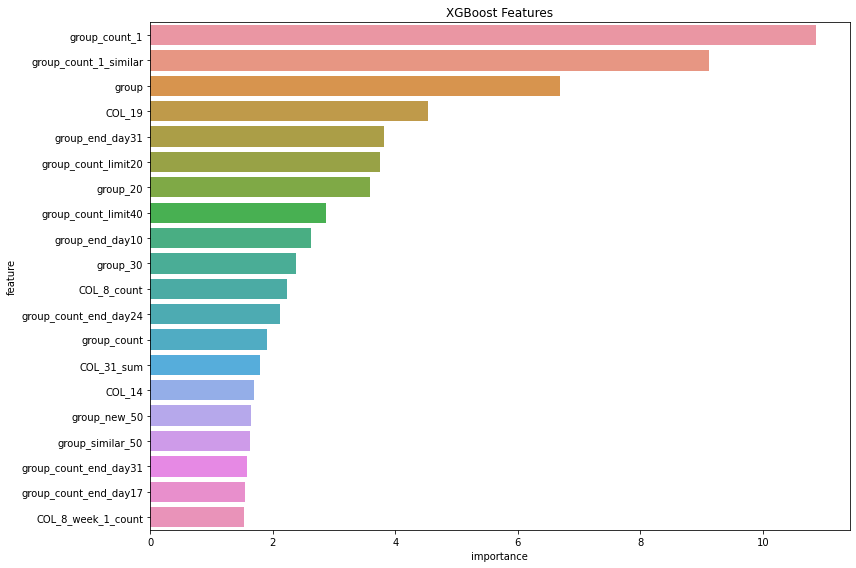

In [ ]:
feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = classes
feature_importance_df["importance"] = gbm.feature_importances_
def display_importances(feature_importance_df_):

    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:20].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('XGBoost Features')
    plt.tight_layout()
display_importances(feature_importance_df)

## Xgboost

### Chưa tunning

In [ ]:
# xgbc
!pip install xgboost
from xgboost import XGBRegressor

my_model = XGBRegressor(n_estimators=1000, learning_rate=0.01, n_jobs=-1, scale_pos_weight=weights[1])
my_model.fit(x_train, y_train, 
             eval_metric='auc', 
             eval_set=[(x_train, y_train), (x_val, y_val)], 
             verbose=200)

[13:45:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-auc:0.721284	validation_1-auc:0.721809
[200]	validation_0-auc:0.826694	validation_1-auc:0.811946
[400]	validation_0-auc:0.848894	validation_1-auc:0.825631
[600]	validation_0-auc:0.857689	validation_1-auc:0.829525
[800]	validation_0-auc:0.864441	validation_1-auc:0.832132
[999]	validation_0-auc:0.86996	validation_1-auc:0.834125


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=5.420860771401693,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
x_base = x_val
y_base = y_val

preds = my_model.predict(x_base)
# preds = np.random.rand(len(y_base))
preds_01 = (preds >= 0.5) * 1
roc_auc = roc_auc_score(y_base, preds)

print('Avg GINI score:', 2*roc_auc - 1)
print('Accuracy : ', accuracy_score(y_base, preds_01))
print('f1_score', f1_score(y_base, preds_01), precision_score(y_base, preds_01), recall_score(y_base, preds_01))
print(sum(preds_01), len(preds_01))

Avg GINI score: 0.6682496935221831
Accuracy :  0.8945736434108527
f1_score 0.4831081081081081 0.4420401854714065 0.5325884543761639
1294 11610


### Sử dụng BayesianOptimization để tuning cho model

In [ ]:
!pip install bayesian-optimization
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_val)

def xgb_evaluate(max_depth, gamma, colsample_bytree):
    params = {'eval_metric': 'auc',
              'max_depth': int(max_depth),
              'subsample': 0.8,
              'eta': 0.1,
              'gamma': gamma,
              'objective':"binary:logistic",
              'colsample_bytree': colsample_bytree,
              # 'min_child_weight': min_child_weight
              }
    # Used around 1000 boosting rounds in the full model
    cv_result = xgb.cv(params, dtrain, num_boost_round=100, nfold=5)    
    
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return cv_result['test-auc-mean'].iloc[-1]
  
xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (3, 7), 
                                             'gamma': (0, 1),
                                             'colsample_bytree': (0.3, 1),
                                            #  'min_child_weight': (0.1, 200)
                                             })
# Use the expected improvement acquisition function to handle negative numbers
# Optimally needs quite a few more initiation points and number of iterations
xgb_bo.maximize(init_points=3, n_iter=5, acq='ei')
params = xgb_bo.max['params']
params['max_depth'] = int(params['max_depth'])
print(params)



|   iter    |  target   | colsam... |   gamma   | max_depth |
-------------------------------------------------------------
|  1        |  0.8854   |  0.7286   |  0.7944   |  6.211    |
|  2        |  0.8804   |  0.4331   |  0.8826   |  3.288    |
|  3        |  0.8859   |  0.6098   |  0.3526   |  6.427    |
|  4        |  0.8859   |  0.9889   |  0.008885 |  6.978    |
|  5        |  0.886    |  0.3127   |  0.8133   |  6.993    |
|  6        |  0.8847   |  0.9659   |  0.9204   |  6.981    |
|  7        |  0.8883   |  0.4484   |  0.004478 |  6.999    |
|  8        |  0.8872   |  0.3038   |  0.03085  |  6.966    |
{'colsample_bytree': 0.44844255082675544, 'gamma': 0.004477924464888039, 'max_depth': 6}


In [ ]:
# Train a new model with the best parameters from the search
modelXGBR = xgb.XGBRegressor(colsample_bytree = params['colsample_bytree'], 
                          gamma = params['gamma'], max_depth = params['max_depth'], 
                          # min_child_weight = params['min_child_weight'],
                          objective="binary:logistic",
                          n_estimators=1000, learning_rate=0.1, n_jobs=-1,
                          num_boost_round=250, scale_pos_weight=weights[1])
modelXGBR.fit(x_train, y_train, 
              early_stopping_rounds=100, 
              eval_metric='auc', 
              eval_set=[(x_train, y_train), (x_val, y_val)], 
              verbose=200)

[0]	validation_0-auc:0.806269	validation_1-auc:0.775698
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[200]	validation_0-auc:0.983157	validation_1-auc:0.887308
Stopping. Best iteration:
[190]	validation_0-auc:0.981683	validation_1-auc:0.887604



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.44844255082675544,
             gamma=0.004477924464888039, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
             nthread=None, num_boost_round=250, objective='binary:logistic',
             random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=5.4533018867924525, seed=None, silent=None,
             subsample=1, verbosity=1)

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
x_base = x_val
y_base = y_val

preds = modelXGBR.predict(x_base)
# preds = pd.DataFrame(preds)
# preds = preds[1].values
preds = preds
# preds = np.random.rand(len(y_base))
preds_01 = (preds >= 0.5) * 1
roc_auc = roc_auc_score(y_base, preds)

print('Avg GINI score:', 2*roc_auc - 1)
print('Accuracy : ', accuracy_score(y_base, preds_01))
print('f1_score', f1_score(y_base, preds_01), precision_score(y_base, preds_01), recall_score(y_base, preds_01))
print(sum(preds_01), len(preds_01))

Avg GINI score: 0.775207053498147
Accuracy :  0.9213855684495245
f1_score 0.5928603705377316 0.5815602836879432 0.6046082949308755
1128 11461


In [ ]:
val_data['preds'] = preds

val_data['rmse'] = (val_data['label'] - preds) * (val_data['label'] - preds)

In [ ]:
val_data

,msisdn,label,COL_13,COL_14,COL_15,COL_16,COL_17,COL_18,COL_19,COL_20,COL_21,COL_22,COL_27a,COL_27b,COL_27c,COL_27d,COL_25_min,COL_23_sum,COL_23_count,COL_23_mean,COL_23_min,COL_23_max,COL_23_std,COL_24_sum,COL_24_count,COL_24_mean,COL_24_min,COL_24_max,COL_24_std,COL_24a_sum,COL_24a_count,COL_24a_mean,COL_24a_min,COL_24a_max,COL_24a_std,COL_24b_sum,COL_24b_count,COL_24b_mean,COL_24b_min,COL_24b_max,...,group_20_similar,group_count_1_similar,group_count_1,group_30,group_similar_50,group_new_50,group_new_20,group_dendrogram,group_dendrogram_2,group_35,Unnamed: 0_y,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,group_end_day10,group_end_day17,group_end_day24,group_end_day31,group_count_end_day10,group_count_end_day17,group_count_end_day24,group_count_end_day31,group_limit0,group_limit10,group_limit20,group_limit30,group_limit40,group_limit50,group_limit60,group_limit70,group_limit80,group_limit90,group_count_limit0,group_count_limit10,group_count_limit20,group_count_limit30,group_count_limit40,group_count_limit50,preds,rmse
7,000101327f45cacc175c,0,0,40.0,20,1,0,0,119781.324219,105510.824219,0.0,2570.5,8546290.91,129489.256212,81923.432310,166969.530,319.0,1.0,2.0,0.500000,0.0,1.0,0.707107,15000000.0,2.0,7.500000e+06,-100000000.0,115000000.0,1.520280e+08,115000000.0,2.0,5.750000e+07,-0.0,115000000.0,8.131728e+07,-100000000.0,2.0,-5.000000e+07,-100000000.0,0.0,...,404.0,306.0,46.0,669.0,1363.0,692.0,34.0,156.0,814.0,26.0,7,7,7,7,540.0,53.0,270.0,147.0,229.0,527.0,286.0,58.0,168.0,54.0,358.0,118.0,24.0,171.0,246.0,580.0,302.0,535.0,128.0,51.0,36.0,112.0,25.0,571.0,0.075723,0.005734
8,00010132e962f636f960,0,0,40.0,20,1,0,0,190917.289062,67287.783203,0.0,7529.5,1721633.92,25696.028657,24751.962917,13613.670,323.0,1.0,2.0,0.500000,0.0,1.0,0.707107,15000000.0,2.0,7.500000e+06,-100000000.0,115000000.0,1.520280e+08,115000000.0,2.0,5.750000e+07,-0.0,115000000.0,8.131728e+07,-100000000.0,2.0,-5.000000e+07,-100000000.0,0.0,...,1001.0,537.0,16.0,157.0,1067.0,695.0,475.0,54.0,54.0,125.0,8,8,8,8,387.0,540.0,50.0,55.0,264.0,528.0,51.0,57.0,57.0,23.0,399.0,126.0,503.0,576.0,533.0,481.0,544.0,537.0,56.0,237.0,120.0,499.0,513.0,474.0,0.069646,0.004851
13,000101f237ef8d7141fd,0,0,40.0,20,1,0,0,93871.308594,69636.808594,0.0,1559.5,1855075.54,21570.645814,13994.786756,21267.420,319.0,2.0,4.0,0.500000,0.0,1.0,0.577350,30000000.0,4.0,7.500000e+06,-100000000.0,115000000.0,1.241303e+08,230000000.0,4.0,5.750000e+07,-0.0,115000000.0,6.639528e+07,-200000000.0,4.0,-5.000000e+07,-100000000.0,0.0,...,100.0,2408.0,155.0,663.0,99.0,113.0,583.0,85.0,107.0,462.0,13,13,13,13,738.0,164.0,297.0,83.0,747.0,676.0,306.0,88.0,83.0,257.0,308.0,671.0,650.0,769.0,786.0,114.0,780.0,197.0,200.0,79.0,603.0,702.0,130.0,810.0,0.114004,0.012997
17,0001025bb53fe8052884,0,0,40.0,20,1,0,0,29367.799805,13740.250000,0.0,10500.0,1718324.00,26035.212121,12846.037177,26010.350,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,...,887.0,63.0,60.0,4077.0,5060.0,1115.0,705.0,40.0,43.0,777.0,17,17,17,17,841.0,745.0,20.0,24.0,844.0,747.0,122.0,20.0,42.0,48.0,41.0,734.0,799.0,856.0,874.0,901.0,888.0,886.0,24.0,18.0,675.0,782.0,864.0,911.0,0.071567,0.005122
19,0001028f9e65b8453f83,0,S022004,19.0,48,1,2128,825,0.000000,0.000000,0.0,0.0,349.14,5.290000,0.000000,5.290,311.0,2.0,3.0,0.666667,0.0,1.0,0.577350,14950000.0,3.0,4.983333e+06,-100000000.0,100027900.0,1.003836e+08,114950000.0,3.0,3.831667e+07,-0.0,100027900.0,5.396179e+07,-100000000.0,3.0,-3.333333e+07,-100000000.0,0.0,...,3240.0,6250.0,5364.0,4078.0,5061.0,1169.0,727.0,10.0,9.0,811.0,19,19,19,19,879.0,774.0,2.0,9.0,890.0,776.0,2.0,9.0,9.0,8.0,676.0,764.0,831.0,895.0,908.0,950.0,932.0,936.0,10.0,56.0,698.0,817.0,903.0,951.0,0.034123,0.001164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
val_data.group_count_1.value_counts()

32.0       205
129.0      193
39.0       154
26.0       137
85.0       132
          ... 
8841.0       1
27616.0      1
8528.0       1
2892.0       1
15820.0      1
Name: group_count_1, Length: 4448, dtype: int64

In [ ]:
val_data.loc[val_data.group_count_1 == 32][['label', 'preds']]

,label,preds
595,0,0.098400
1473,0,0.071594
1690,0,0.064437
1900,0,0.071289
2068,0,0.002945
...,...,...
55716,1,0.193892
55778,1,0.037129
57062,1,0.672784
57182,1,0.977842


In [ ]:
arpu_train['preds'] = modelXGBR.predict(arpu_train[classes].to_numpy())

In [ ]:
arpu_train.group.value_counts()[:10]

6      2858
102    2037
8      1657
95     1481
114    1267
46     1177
48     1120
67      733
24      630
108     618
Name: group, dtype: int64

In [ ]:
top5 = arpu_train.loc[arpu_train.group.isin([6, 102, 8, 95, 114, 46])]


In [ ]:
top5 = top5.groupby('group').agg({'label': ['count', 'sum']})
top5.columns = top5.columns.map("_".join)

In [ ]:
top5 = top5.reset_index()
top5

,group,label_count,label_sum
0,6,2858,659
1,8,1657,59
2,46,1177,58
3,95,1481,815
4,102,2037,951
5,114,1267,31


In [ ]:
top5['label_0'] = top5['label_count'] - top5['label_sum']

0 2858 659.0
1 1657 59.0
2 1177 58.0
3 1120 815.0
4 1481 951.0
5 2037 31.0
6 1267 2199.0
7 2858 1598.0
8 1657 1119.0
9 1177 666.0
10 1120 1086.0
11 1481 1236.0


Text(0.5, 1.0, 'Tương quan giữa label 0 và 1 của top 6 group đông nhất')

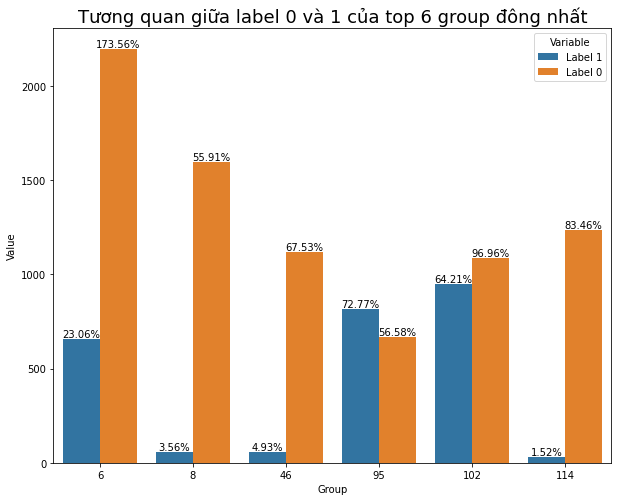

In [ ]:
df = pd.DataFrame({
    'Group': top5.group.values,
    
    'Label 1': top5.label_sum,
    'Label 0': top5.label_0,
    # 'Total': [3002+19663, 2325+32731, 5327+52394],
})
fig, ax1 = plt.subplots(figsize=(10, 8))
tidy = df.melt(id_vars='Group').rename(columns=str.title)
sns.barplot(x='Group', y='Value', hue='Variable', data=tidy, ax=ax1)

total = [2858, 1657, 1177, 1120, 1481, 2037, 1267]

for stt, p in enumerate(ax1.patches):
    height = p.get_height()
    print(stt, total[stt%7], height)
    ax1.text(p.get_x()+p.get_width()/2.,
            height + 10,
            '{:1.2f}%'.format(height*100/total[stt%7]),
            ha="center") 

ax1.set_title("Tương quan giữa label 0 và 1 của top 6 group đông nhất", fontsize=18)

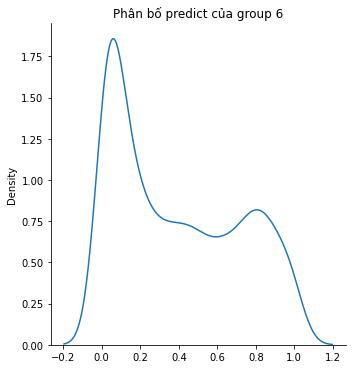

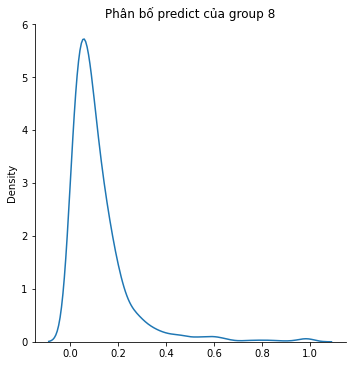

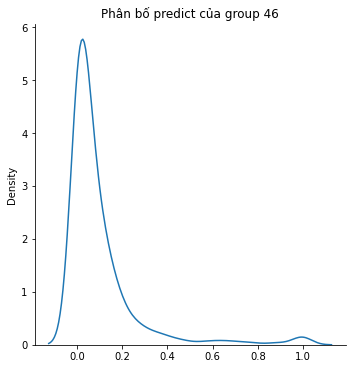

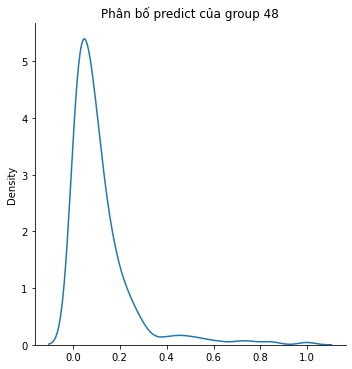

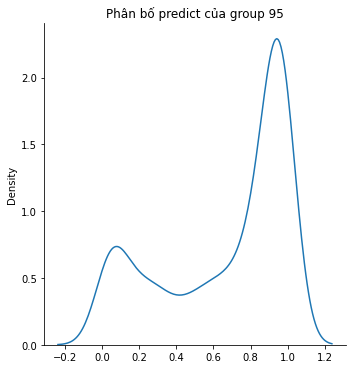

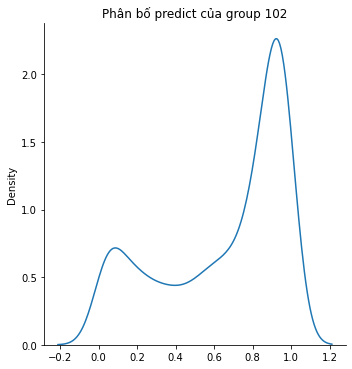

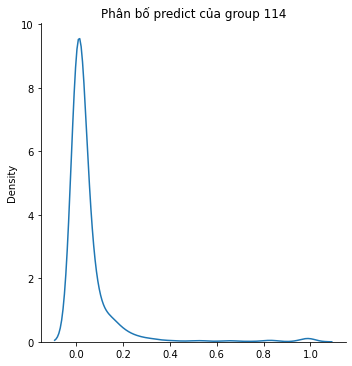

In [ ]:
#  fig, ax = plt.subplots(4, 2,figsize=(15, 30))
 
stt = 0
for i in [6, 8, 46, 48, 95, 102, 114]:
   group = arpu_train[arpu_train['group'] == i]
   sns.displot(group['preds'].values,kind= "kde")
   plt.title("Phân bố predict của group " + str(i))
   stt=stt+1

In [ ]:
arpu_train[arpu_train.group == 95].label.value_counts()

1    815
0    666
Name: label, dtype: int64

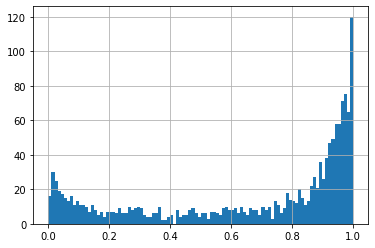

In [ ]:
arpu_train[arpu_train.group == 95].preds.hist(bins=100)

In [ ]:
val_data.loc[val_data.preds > 0.9].label.value_counts()

1    333
0     52
Name: label, dtype: int64

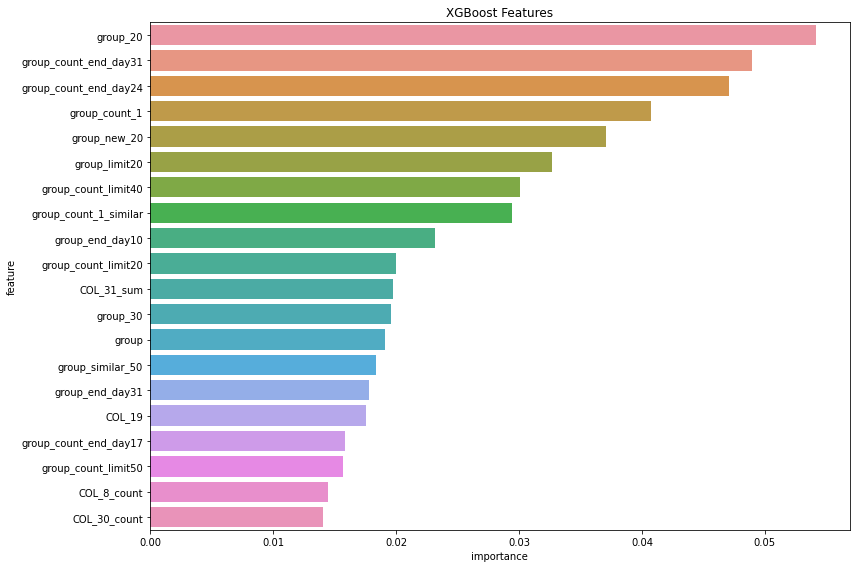

In [ ]:
feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = classes
feature_importance_df["importance"] = modelXGBR.feature_importances_
def display_importances(feature_importance_df_):

    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:20].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('XGBoost Features')
    plt.tight_layout()
display_importances(feature_importance_df)

## LGBM

In [ ]:
#LGBM
from lightgbm import LGBMModel,LGBMRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from hyperopt import hp, tpe, fmin
from sklearn.model_selection import cross_val_score

lgbm = LGBMRegressor(eval_metric='auc',
                        use_best_model=True,
                        n_estimators=1000, 
                        learning_rate=0.01, 
                        depth=7,
                     class_weight=weights)
lgbm.fit(x_train, y_train, eval_set=[(x_train, y_train)], eval_metric='auc', verbose=500)

# lgbm =  LGBMRegressor(objective='binary',metrics ='auc', class_weight=weights)
# lgbm.fit(x_train, y_train)



[500]	training's auc: 0.930879	training's l2: 0.114628
[1000]	training's auc: 0.95786	training's l2: 0.0942028


LGBMRegressor(boosting_type='gbdt',
              class_weight={0: 0.550471383677745, 1: 5.4533018867924525},
              colsample_bytree=1.0, depth=7, eval_metric='auc',
              importance_type='split', learning_rate=0.01, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
              use_best_model=True)

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
x_base = x_val
y_base = y_val
preds = lgbm.predict(x_base)
# preds = np.random.rand(len(y_base))
preds_01 = (preds >= 0.5) * 1
roc_auc = roc_auc_score(y_base, preds)

print('Avg GINI score:', 2*roc_auc - 1)
print('Accuracy : ', accuracy_score(y_base, preds_01))
print('f1_score', f1_score(y_base, preds_01), precision_score(y_base, preds_01), recall_score(y_base, preds_01))
print(sum(preds_01), len(preds_01))

Avg GINI score: 0.7543151690004226
Accuracy :  0.8709536689643138
f1_score 0.5055165496489469 0.39664218258132217 0.6967741935483871
1906 11461


# Sinh file submit

In [ ]:
def make_submission(model):
  arpu_test['label'] = 0
  x_result, y_result = make_input(arpu_test)
  print(x_result.shape)
  # y_pred = model.predict_proba(x_result)
  # y_pred = pd.DataFrame(y_pred)
  # y_pred = y_pred[1].values
  # y_pred = preds
  y_pred = model.predict(x_result)
  y_pred = np.minimum(y_pred, 1)
  y_pred = np.maximum(y_pred, 0)
  arpu_test['label'] = y_pred
  print(len(arpu_test[arpu_test['label'] >= 0.5]), len(arpu_test))
  arpu_test[['msisdn', 'label']].to_csv('result.csv', index=False)
make_submission(modelXGBR)
# modelXGBR lgbm gbm my_model cfl

(57445, 76)
5956 57445


In [ ]:
def merge_submission(file_name):
  result = pd.read_csv(file_name + '.csv')
  test_submission = pd.read_csv(path + 'test_submission.csv')
  del test_submission['label']
  test_submission = test_submission.merge(result, on='msisdn', how='left')
  test_submission.to_csv(file_name + '_final.csv', index=False)
  print(len(test_submission))
merge_submission('result')
# merge_submission('xgboost_70')

57413


In [ ]:
result = pd.read_csv("result_final.csv")

In [ ]:
# arpu_train = pd.read_csv('xgboost_66_similar_36_features.csv')
result.to_csv(path + 'xgboost_classification_78_15_groups_76_features_95_data.csv', index=False)
# print(len(result[result['label'] >= 0.5]), len(result))

In [ ]:
test_table = train_data
print(len(test_table[test_table['label'] == 1]), len(test_table))

4268 46192


In [ ]:
!pip install -U pandas-profiling
# pp.ProfileReport(val_data)

Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.9.0)


In [ ]:
import pandas_profiling as pp

In [ ]:
preds

array([0.07751687, 0.14856504, 0.22076727, ..., 0.32755417, 0.02994751,
       0.21151517], dtype=float32)

In [ ]:
val_data.to_csv(path + 'val_rmse.csv', index=False)

In [ ]:
val_data['preds'] = preds

In [ ]:
val_data['rmse'] = np.abs(val_data['preds'] - val_data['label'])

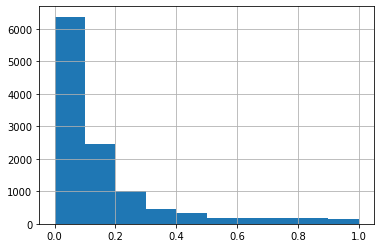

In [ ]:
val_data[['msisdn', 'label', 'preds', 'rmse']].sort_values('rmse')['rmse'].hist()

In [ ]:
len(val_data.loc[val_data.rmse > 0.5])*100/len(val_data)

7.4513567751505105

In [ ]:
len(val_data.loc[val_data.rmse > 0.8])

319

In [ ]:
error = arpu_train.loc[arpu_train.msisdn.isin(val_data[['msisdn', 'label', 'preds', 'rmse']].loc[val_data.rmse > 0.5].msisdn.values)]

In [ ]:
arpu_train.loc[arpu_train.group == 6].label.value_counts()

0    2199
1     659
Name: label, dtype: int64

In [ ]:
error.loc[error.group == 6]

,msisdn,label,COL_13,COL_14,COL_15,COL_16,COL_17,COL_18,COL_19,COL_20,COL_21,COL_22,COL_27a,COL_27b,COL_27c,COL_27d,COL_25_min,COL_23_sum,COL_23_count,COL_23_mean,COL_23_min,COL_23_max,COL_23_std,COL_24_sum,COL_24_count,COL_24_mean,COL_24_min,COL_24_max,COL_24_std,COL_24a_sum,COL_24a_count,COL_24a_mean,COL_24a_min,COL_24a_max,COL_24a_std,COL_24b_sum,COL_24b_count,COL_24b_mean,COL_24b_min,COL_24b_max,...,group_20,group_20_similar,group_count_1_similar,group_count_1,group_30,group_similar_50,group_new_50,group_new_20,group_dendrogram,group_dendrogram_2,group_35,Unnamed: 0_y,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,group_end_day10,group_end_day17,group_end_day24,group_end_day31,group_count_end_day10,group_count_end_day17,group_count_end_day24,group_count_end_day31,group_limit0,group_limit10,group_limit20,group_limit30,group_limit40,group_limit50,group_limit60,group_limit70,group_limit80,group_limit90,group_count_limit0,group_count_limit10,group_count_limit20,group_count_limit30,group_count_limit40,group_count_limit50,num_mem
12,00015a3cd19a6b87b8e1,0,P057009,10.0,41,1,1092,948,8.758850e+04,28213.499023,0.0,46750.0,1.318153e+05,1997.201364,6290.970969,4.2100,332.0,0.0,1.0,0.000000,0.0,0.0,0.000000,-100000000.0,1.0,-1.000000e+08,-100000000.0,-100000000.0,0.000000e+00,0.000000e+00,1.0,0.000000e+00,-0.0,-0.0,0.000000e+00,-1.000000e+08,1.0,-1.000000e+08,-100000000.0,-100000000.0,...,6.0,328.0,1248.0,954.0,712.0,958.0,41.0,8.0,11.0,10.0,72.0,980,980,980,980,6.0,7.0,8.0,36.0,6.0,7.0,8.0,3.0,4.0,9.0,9.0,6.0,519.0,295.0,614.0,763.0,518.0,192.0,4.0,9.0,8.0,7.0,825.0,26.0,2858
13,0001b37885d8a5f260a6,0,D061011,22.0,13,1,2562,760,3.323346e+06,2152.125000,0.0,3240943.5,3.716356e+06,56308.423333,72518.236805,39974.0700,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,...,304.0,551.0,2710.0,986.0,613.0,585.0,5.0,18.0,11.0,10.0,100.0,2024,2024,2024,2024,23734.0,7.0,8.0,36.0,23748.0,7.0,8.0,3.0,10.0,9.0,158.0,98.0,448.0,1033.0,585.0,1125.0,1111.0,1139.0,4.0,139.0,204.0,627.0,1122.0,462.0,2858
14,0001c2ea99df7054a28f,1,L072008,23.0,34,1,2830,1357,1.283888e+05,463.750000,0.0,0.0,1.070106e+06,16213.733333,14188.226133,23572.6500,325.0,1.0,2.0,0.500000,0.0,1.0,0.707107,15000000.0,2.0,7.500000e+06,-100000000.0,115000000.0,1.520280e+08,1.150000e+08,2.0,5.750000e+07,-0.0,115000000.0,8.131728e+07,-1.000000e+08,2.0,-5.000000e+07,-100000000.0,0.0,...,928.0,188.0,657.0,698.0,748.0,486.0,5.0,8.0,11.0,10.0,973.0,2214,2214,2214,2214,6.0,7.0,8.0,36.0,6.0,7.0,8.0,143.0,137.0,146.0,9.0,894.0,894.0,299.0,318.0,1648.0,164.0,2705.0,4.0,9.0,8.0,7.0,525.0,644.0,2858
15,0001274ad360bb77b74e,0,T008BI,29.0,50,0,4269,2156,2.352678e+05,228108.835938,0.0,2409.0,1.508349e+06,22853.778636,17124.941315,21513.4900,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,...,6.0,997.0,98.0,129.0,6.0,1089.0,186.0,8.0,11.0,10.0,3.0,3330,3330,3330,3330,6.0,7.0,8.0,36.0,6.0,7.0,8.0,3.0,4.0,9.0,9.0,6.0,3.0,6.0,586.0,231.0,2002.0,991.0,4.0,9.0,8.0,7.0,6.0,6.0,2858
16,0001f1dd988ee5bc2ca9,0,D501006,37.0,17,1,2778,2802,1.450651e+05,33640.140625,0.0,20500.0,1.370447e+06,20764.341212,27638.124412,10009.5200,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,...,6.0,739.0,1127.0,153.0,388.0,1091.0,106.0,8.0,11.0,10.0,3.0,5495,5495,5495,5495,6.0,7.0,8.0,36.0,6.0,7.0,73.0,3.0,10.0,9.0,9.0,6.0,93.0,10.0,1164.0,1138.0,478.0,152.0,4.0,9.0,8.0,7.0,84.0,945.0,2858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [ ]:
error.num_mem.value_counts()

2858    141
2037    130
1481     66
1        20
120      12
       ... 
52        1
51        1
198       1
45        1
157       1
Name: num_mem, Length: 152, dtype: int64

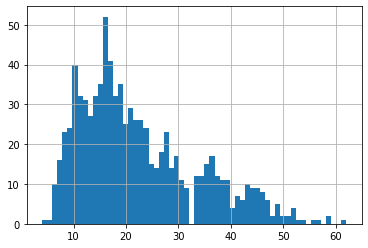

In [ ]:
error.COL_14.hist(bins=60)

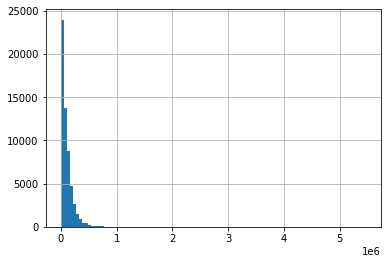

In [ ]:
arpu_train.COL_19.hist(bins=100)

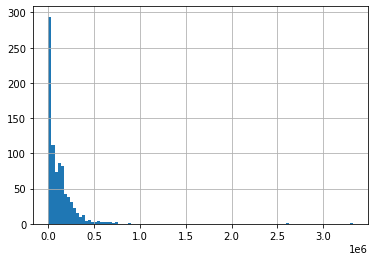

In [ ]:
error.COL_19.hist(bins=100)

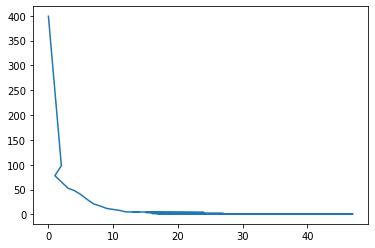

In [ ]:
plt.plot(error.COL_23_count.value_counts())

In [ ]:
def count_null(row):
  c = 0
  for i in row[2:]:
    if i == 0:
      c = c + 1
  return c

val_data['count_null'] = val_data.apply(count_null, axis=1)
error['count_null'] = error.apply(count_null, axis=1)

In [ ]:
val_data.shape

(11461, 218)

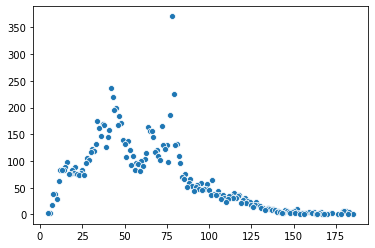

In [ ]:
count_null_sr = val_data.count_null.value_counts()
sns.scatterplot(x=count_null.index, y=count_null.values)

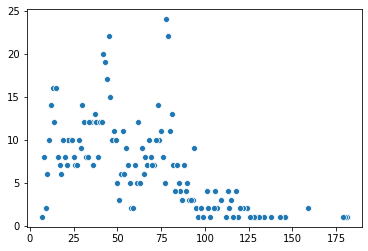

In [ ]:
count_null_sr = error.count_null.value_counts()
sns.scatterplot(x=count_null_sr.index, y=count_null_sr.values)

In [ ]:
count_group = arpu_train.groupby('group')[['msisdn']].count().sort_values('msisdn').reset_index()
count_group.columns = ['group', 'num_mem']

In [ ]:
count_group.num_mem.value_counts()

1       4557
2         48
29        16
31        12
21        11
        ... 
1481       1
1177       1
733        1
2858       1
4          1
Name: num_mem, Length: 192, dtype: int64

In [ ]:
error = error.merge(count_group, on='group')

In [ ]:
arpu_train.loc[arpu_train.group == 102].label.value_counts(
    
)

0    1086
1     951
Name: label, dtype: int64

In [ ]:
community.loc[community.group == 102]

,Unnamed: 0,msisdn,group,group_similar,group_count,group_sum_weight,group_count_similar,group_20,group_20_similar,group_count_1_similar,group_count_1,group_30,group_similar_50,group_new_50,group_new_20,group_dendrogram,group_dendrogram_2,group_35
149,149,00010b045f1d48d9e6af,102,56,94,54,133,6.0,55.0,140.0,129.0,6.0,55.0,4.0,8.0,11.0,10.0,3.0
179,179,00010d4d97589e8b64be,102,159,5,155,159,6.0,160.0,168.0,161.0,155.0,157.0,3308.0,8.0,11.0,10.0,533.0
302,302,000114c5d2f35035b150,102,137,94,261,255,6.0,139.0,134.0,251.0,6.0,136.0,52.0,8.0,11.0,102.0,3.0
317,317,0001159efbdbc6d8d047,102,74,94,54,133,6.0,281.0,250.0,264.0,6.0,73.0,162.0,8.0,11.0,10.0,3.0
376,376,0001197a6f4e38721b59,102,323,94,321,133,6.0,327.0,329.0,302.0,6.0,321.0,79.0,8.0,1693.0,10.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115143,115143,00019aa94ea996bda0ed,102,917,94,911,126,6.0,1570.0,166.0,129.0,6.0,1002.0,312.0,8.0,424.0,655.0,3.0
115147,115147,0001abcba8a73562906b,102,175,94,171,402,6.0,175.0,452.0,28.0,6.0,7.0,51.0,8.0,34.0,10.0,3.0
115150,115150,0001b7e05c247adeb0a6,102,339,94,335,1223,65.0,956.0,491.0,1083.0,796.0,725.0,162.0,148.0,11.0,10.0,3.0
115151,115151,0001becc61b4d5089e3f,102,56,94,54,133,6.0,55.0,98.0,129.0,6.0,55.0,4.0,8.0,11.0,10.0,3.0


In [ ]:
test_102 = arpu_test.loc[arpu_test.group.isin([102, 95, 6, 146])]

In [ ]:
arpu_train.loc[arpu_train.label == 1].group.value_counts()

102     951
95      815
6       659
146      70
8        59
       ... 
597       1
8793      1
6750      1
8801      1
8837      1
Name: group, Length: 677, dtype: int64

In [ ]:
group_102 = arpu_train.loc[arpu_train.group.isin([102, 95, 6, 146])]

In [ ]:
temp_102 = temp.loc[temp.msisdn.isin(group_102.msisdn.values.tolist() + test_102.msisdn.values.tolist())]

In [ ]:
temp_102 = temp_102.dropna()

In [ ]:
nice_id = temp_102.loc[temp_102.PARTNER_MSISDN.isin(group_102.msisdn.values)].drop_duplicates(['msisdn', 'PARTNER_MSISDN'], keep='first')

In [ ]:
id = nice_id.msisdn.values.tolist() + nice_id.PARTNER_MSISDN.values.tolist()

In [ ]:
len(id)

454

In [ ]:
temp_loc = temp.loc[temp.msisdn.isin(id)].loc[temp.PARTNER_MSISDN.isin(id)]
temp_loc = temp_loc.drop_duplicates(['msisdn', 'PARTNER_MSISDN'], keep='first')
temp_loc.groupby('msisdn').count().sort_values('COL_1')

,COL_1,COL_8,COL_11,PARTNER_MSISDN,COL_2,UPLOAD_DATA,COL_12
msisdn,,,,,,,
0001007187b4881379a9,1,1,1,1,1,1,1
0001b338057bab4874d3,1,1,1,1,1,1,1
0001b2a3a2afb5b8f308,1,1,1,1,1,1,1
0001b1363e2d1860f63a,1,1,1,1,1,1,1
0001b082fe79eb8af388,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...
0001090ff52250870718,2,2,2,2,2,2,2
000189a36e712e4c61f3,2,2,2,2,2,2,2
000113ea5d7222ff0cc8,2,2,2,2,2,2,2


In [ ]:
temp_loc.loc[temp_loc.msisdn == '0001970f58c79dc8f38b'].groupby('PARTNER_MSISDN').count()

,msisdn,COL_1,COL_8,COL_11,COL_2,UPLOAD_DATA,COL_12
PARTNER_MSISDN,,,,,,,
000113ea5d7222ff0cc8,58,58,58,58,58,58,58
000189a36e712e4c61f3,36,36,36,36,36,36,36


In [ ]:
loan_102 = loan.loc[loan.msisdn.isin(id)]

In [ ]:
recharge_102 = recharge.loc[recharge.msisdn.isin(id)]

In [ ]:
loan_102.to_csv('loan_loc.csv', index=False)
recharge_102.to_csv('recharge_loc.csv', index=False)